# SVM Optimization

## Import libraries

In [63]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np

## Generate sample input and output set

In [41]:
x = [[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [0, 2]]
y = [-1, -1, -1, 1, 1, 1]

In [42]:
data_num = len(x)
feature_num = len(x[0])

## Define Model

In [43]:
model = pyo.ConcreteModel()

## Define Sets

In [44]:
model.data_index    = pyo.Set(initialize=[i for i in range(data_num)])
model.feature_index = pyo.Set(initialize=[i for i in range(feature_num)])

## Define Params

In [45]:
model.data_num      = pyo.Param(domain=pyo.NonNegativeIntegers, initialize=data_num)
model.feature_num   = pyo.Param(domain=pyo.NonNegativeIntegers, initialize=feature_num)
model.C             = pyo.Param(domain=pyo.Reals, default=1e9)

## Define Vars

In [46]:
model.u     = pyo.Var(model.feature_index, domain=pyo.NonNegativeReals)
model.w     = pyo.Var(model.feature_index, domain=pyo.Reals)
model.b     = pyo.Var(domain=pyo.Reals)
model.relax = pyo.Var(model.data_index, domain=pyo.NonNegativeReals)

## Define Objective

In [47]:
def objective(model: pyo.ConcreteModel):
    return pyo.summation(model.u) + model.C * pyo.summation(model.relax)

model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)

## Define Constraints

In [48]:
for i in range(feature_num):
    setattr(model, f'abs_constraint_1_{i}', pyo.Constraint(expr=model.u[i] >= model.w[i]))
    setattr(model, f'abs_constraint_2_{i}', pyo.Constraint(expr=model.u[i] >= -model.w[i]))

for i in range(data_num):
    setattr(model, f'constraint_{i+1}', pyo.Constraint(expr=y[i] * (pyo.summation(x[i], model.w) + model.b) + model.relax[i] >= 1))

## Determine Solver

In [49]:
solver_name = 'glpk'
opt = pyo.SolverFactory(solver_name)
result=opt.solve(model)

## Show Output

In [50]:
model.display()

Model unknown

  Variables:
    u : Size=2, Index=feature_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   2.0 :  None : False : False : NonNegativeReals
          1 :     0 :   2.0 :  None : False : False : NonNegativeReals
    w : Size=2, Index=feature_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :   2.0 :  None : False : False :  Reals
          1 :  None :   2.0 :  None : False : False :  Reals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  -3.0 :  None : False : False :  Reals
    relax : Size=6, Index=data_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :  None : False : False : NonNegativeReals
          1 :     0 :   0.0 :  None : False : False : NonNegativeReals
          2 :     0 :   0.0 :  None : False : False : NonNegativeReals
          3 :     0 :   0.0 :  None : False : False 

## Plot Output

In [51]:
w_0 = pyo.value(model.w[0])
w_1 = pyo.value(model.w[1])
b   = pyo.value(model.b)
w_0, w_1, b

(2.0, 2.0, -3.0)

In [61]:
a_ = -w_0 / w_1
b_ = -b / w_1
a_, b_

(-1.0, 1.5)

In [59]:
x_neg

[[0, 0], [0, 1], [1, 0]]

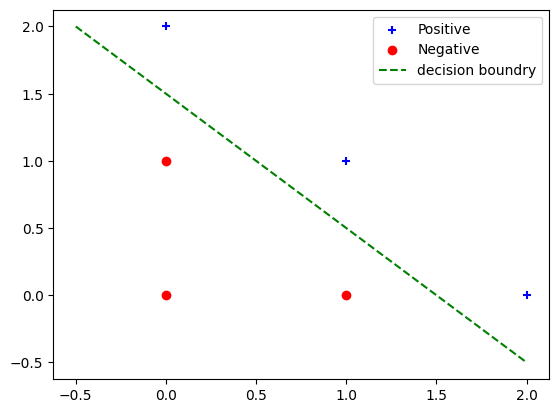

In [66]:
x_pos = [x_elem for i, x_elem in enumerate(x) if y[i] == 1]
x_neg = [x_elem for i, x_elem in enumerate(x) if y[i] == -1]
plt.scatter(list(map(lambda x: x[0], x_pos)), list(map(lambda x: x[1], x_pos)), c='b', marker='+', label='Positive')
plt.scatter(list(map(lambda x: x[0], x_neg)), list(map(lambda x: x[1], x_neg)), c='r', marker='o', label='Negative')

xx = np.linspace(-0.5, 2)
yy = a_ * xx + b_
plt.plot(xx, yy, 'g--', label='decision boundry')
plt.legend()